In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


In [18]:
# Getting the real stock price for Feb 1st 2012 - Dec 31st 2016
df_train = pd.read_csv('Google_Stock_Price_Train.csv')
# Getting the real stock price from Jan 1st 2017 - Feb 1st 2017
test = pd.read_csv('Google_Stock_Price_Test.csv')
df_train = df_train.iloc[:,1:2].values
price_test = test.iloc[:,1:2].values
print('training data size : {}'.format(df_train.shape))
print('testing data size : {}'.format(price_test.shape))



training data size : (1258, 1)
testing data size : (21, 1)


Build model with 20 TIMESTEPS 4LAYER RNN :

In [36]:
def build_classifier(optimizer):
    reg_rnn = Sequential()
    reg_rnn.add(LSTM(units = 4, init = 'normal',return_sequences = True, input_shape = (None, 1)))
    reg_rnn.add(LSTM(units = 4, init = 'normal',return_sequences = True))
    reg_rnn.add(LSTM(units = 4, init = 'normal'))
    reg_rnn.add(Dense(units = 1,init = 'normal'))
    reg_rnn.compile(optimizer = optimizer, loss = 'mean_squared_error')
    return reg_rnn

#reg_rnn.fit(x_train, y_train, batch_size = 32, epochs = 200)
    
    
model = KerasClassifier(build_fn = build_classifier)
parameters = { 'batch_size': [5,20],
               'nb_epoch': [100,400],
               'optimizer': ['adam', 'rmsprop'],
               
                                                               }

#tuning for the best parameter
grid_search = GridSearchCV(estimator = model,
                           param_grid = parameters,  
                           scoring = 'neg_mean_absolute_error',
                           cv = 10)

grids = grid_search.fit(x_train, y_train)
best_parameters = grids.best_params_
best_accuracy = grid_search.best_score_

#summarize results
print("Best: %f using %s" % (best_accuracy, best_parameters))


C:\Users\Mission\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, kernel_initializer="normal", units=4, input_shape=(None, 1))`
  app.launch_new_instance()
C:\Users\Mission\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, kernel_initializer="normal", units=4)`
C:\Users\Mission\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(kernel_initializer="normal", units=4)`
C:\Users\Mission\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="normal", units=1)`


Epoch 1/10
1131/1131 [==============================] - 1s - loss: 395867.6819     
Epoch 2/10
1131/1131 [==============================] - 0s - loss: 393979.4436     
Epoch 3/10
1131/1131 [==============================] - 1s - loss: 392234.6954     
Epoch 4/10
1131/1131 [==============================] - 1s - loss: 391077.9508     
Epoch 5/10
1131/1131 [==============================] - 1s - loss: 390008.6600     
Epoch 6/10
1131/1131 [==============================] - 1s - loss: 388979.4500     
Epoch 7/10
1131/1131 [==============================] - 1s - loss: 387978.8177     
Epoch 8/10
1131/1131 [==============================] - 1s - loss: 386990.9896     
Epoch 9/10
1131/1131 [==============================] - 1s - loss: 386019.0098     
Epoch 10/10
1131/1131 [==============================] - 1s - loss: 399140.0697     
Epoch 2/10
1131/1131 [==============================] - 1s - loss: 397322.7441     
Epoch 3/10
1131/1131 [==============================] - 1s - loss: 395574.8

In [37]:

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(df_train)

# Creating a data structure with 20 timesteps and t+1 output
x_train = []
y_train = []

for i in range(20, 1258):
    x_train.append(train_scaled[i-20:i, 0])
    y_train.append(train_scaled[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshaping
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# 3-layer RNN
reg_rnn = Sequential()
reg_rnn.add(LSTM(units = 4, return_sequences = True, input_shape = (None, 1)))
reg_rnn.add(LSTM(units = 4, return_sequences = True))
reg_rnn.add(LSTM(units = 4 ))
reg_rnn.add(Dense(units = 1))
reg_rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')
reg_rnn.fit(x_train, y_train, batch_size = 5, epochs = 100)


# predict the stock price
real_stock_price = np.concatenate((df_train[0:1258] ,price_test),axis = 0)
scaled_real_stock_price = sc.fit_transform(real_stock_price)
input_x = []
for i in range(1258,1279):
    input_x.append(scaled_real_stock_price[i-20:i, 0]) 

   
input_x = np.array(input_x)
input_x = np.reshape(input_x, (input_x.shape[0], input_x.shape[1], 1) )

predicted_price = reg_rnn.predict(input_x)
predicted_price = sc.inverse_transform(predicted_price)


rmse = math.sqrt(mean_squared_error(real_stock_price[1258:], predicted_price))


Epoch 1/100
1238/1238 [==============================] - 4s - loss: 0.0440     
Epoch 2/100
1238/1238 [==============================] - 4s - loss: 0.0023     
Epoch 3/100
1238/1238 [==============================] - 4s - loss: 0.0021     
Epoch 4/100
1238/1238 [==============================] - 4s - loss: 0.0020     
Epoch 5/100
1238/1238 [==============================] - 4s - loss: 0.0020     
Epoch 6/100
1238/1238 [==============================] - 4s - loss: 0.0019     
Epoch 7/100
1238/1238 [==============================] - 4s - loss: 0.0018     
Epoch 8/100
1238/1238 [==============================] - 4s - loss: 0.0017     
Epoch 9/100
1238/1238 [==============================] - 4s - loss: 0.0016     
Epoch 10/100
1238/1238 [==============================] - 4s - loss: 0.0016     
Epoch 11/100
1238/1238 [==============================] - 4s - loss: 0.0015     
Epoch 12/100
1238/1238 [==============================] - 4s - loss: 0.0014     
Epoch 13/100
1238/1238 [=============

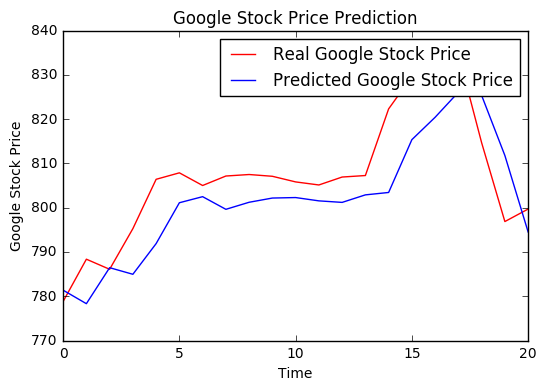

In [38]:
# Visualising the results
plt.plot(real_stock_price[1258:], color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

Build model with 1 TIMESTEPS 4LAYER RNN :

(1257, 1)
Epoch 1/200
1257/1257 [==============================] - 0s - loss: 0.2797     
Epoch 2/200
1257/1257 [==============================] - 0s - loss: 0.2204     
Epoch 3/200
1257/1257 [==============================] - 0s - loss: 0.1671     
Epoch 4/200
1257/1257 [==============================] - 0s - loss: 0.1218     
Epoch 5/200
1257/1257 [==============================] - 0s - loss: 0.0913     
Epoch 6/200
1257/1257 [==============================] - 0s - loss: 0.0782     
Epoch 7/200
1257/1257 [==============================] - 0s - loss: 0.0751     
Epoch 8/200
1257/1257 [==============================] - 0s - loss: 0.0744     
Epoch 9/200
1257/1257 [==============================] - 0s - loss: 0.0737     
Epoch 10/200
1257/1257 [==============================] - 0s - loss: 0.0729     
Epoch 11/200
1257/1257 [==============================] - 0s - loss: 0.0720     
Epoch 12/200
1257/1257 [==============================] - 0s - loss: 0.0710     
Epoch 13/200
1257/1257 [===

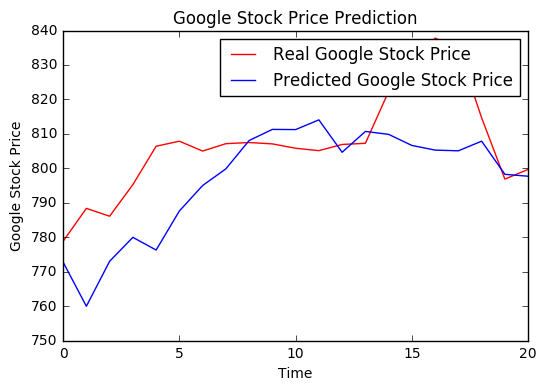

In [24]:


x_train = train_scaled[0:1257]
print(x_train.shape)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
y_train = train_scaled[1:1258]



# Initialising the RNN
reg_rnn1 = Sequential()
reg_rnn1.add(LSTM(units = 4,  return_sequences = True, activation = 'sigmoid', input_shape = (None, 1)))
reg_rnn1.add(LSTM(units = 4, return_sequences = True))
reg_rnn1.add(LSTM(units = 3))
reg_rnn1.add(Dense(units = 1))
reg_rnn1.compile(optimizer = 'adam', loss = 'mean_squared_error')
reg_rnn1.fit(x_train, y_train, batch_size = 32, epochs = 200)

# predicted stock price of 2017
inputs = train_scaled[1237:1258]
inputs = np.reshape(inputs, (21, 1, 1))
predictions = regressor.predict(inputs)
predicted_stock_price = sc.inverse_transform(predictions)

# Visualising the results
plt.plot(price_test, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()


